# Exploratory Data Analysis Project with AWS S3 + Snowflake SQL 

## Introduction

This short project was completed as part of a job interview assessment for a mental health startup. For the sake of privacy and maintaining anonymity, I am using the name "Whole-Health" instead of the actual company's name.

<br>

<div align="center">
    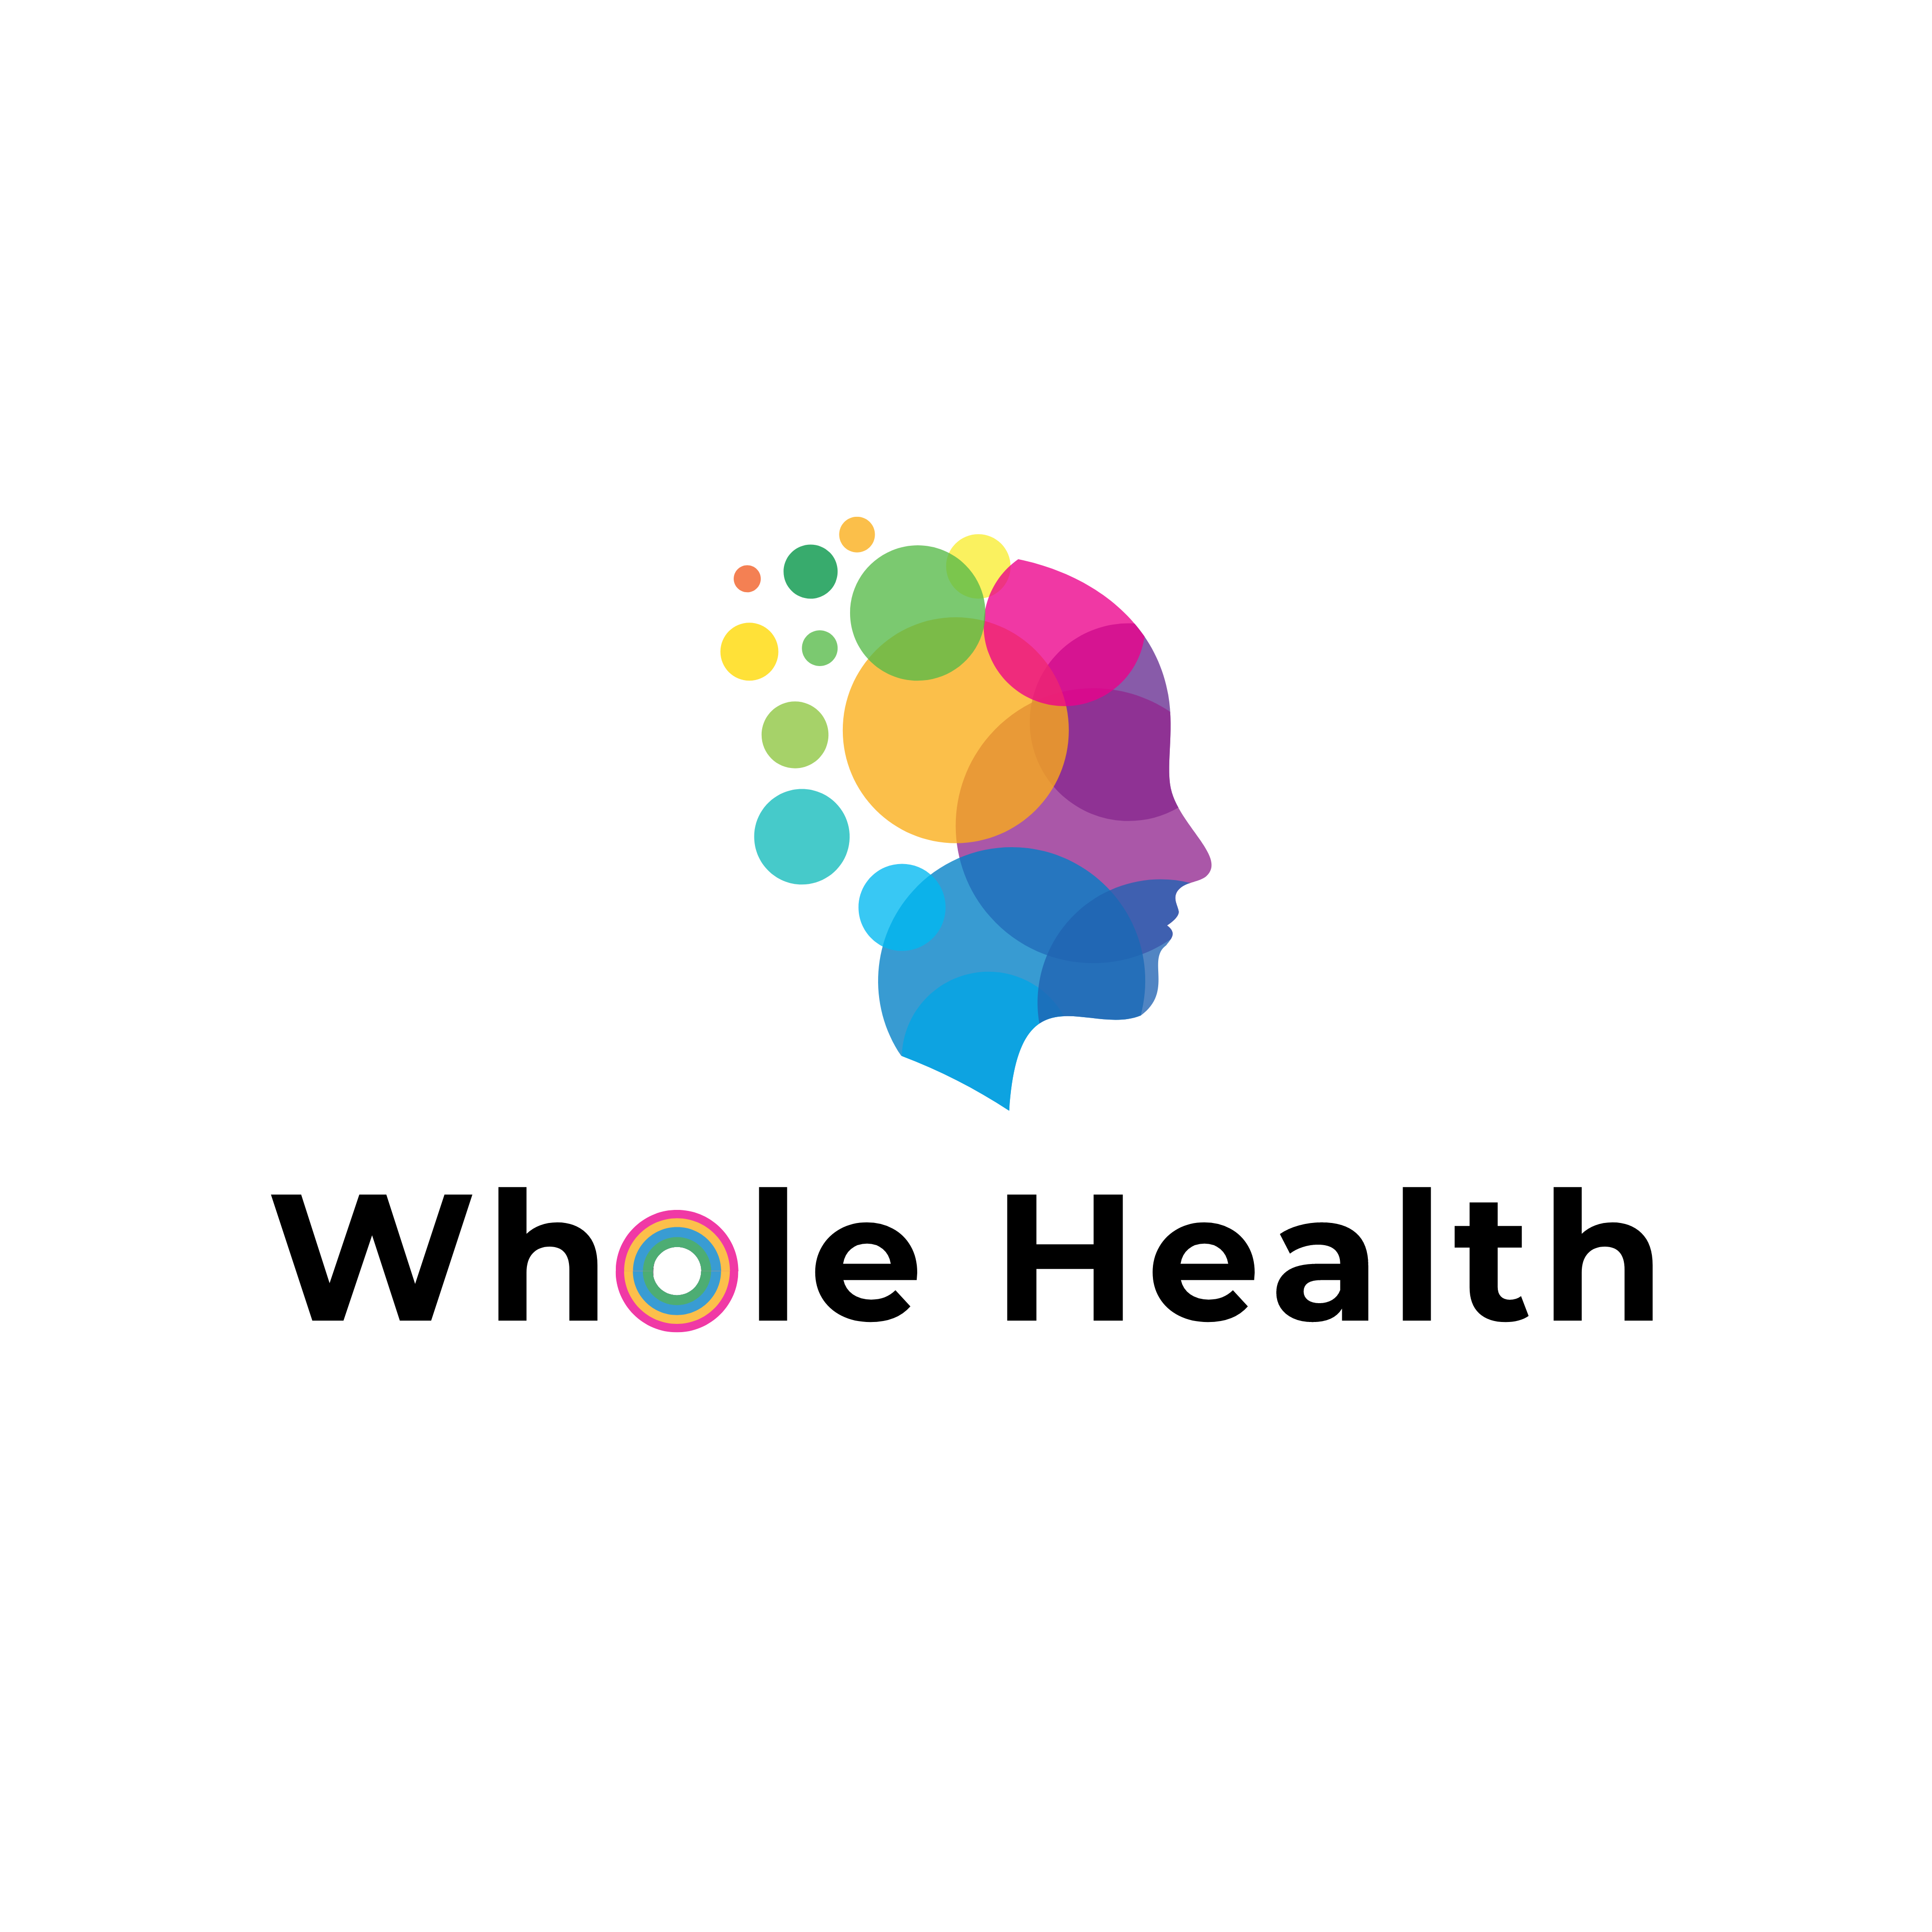
</div>





Whole Health leverages AI, Data Science and Clinical Data to provide affordable, high-quality mental health care to patients, all from the comfort and privacy of their homes.
Senior executives of Whole Health engaged my services to help them analyzing patients data in their database, to investigate the impact of patient’s mental health PHQ assessment on drug prescription and frequency.


<br>


### Datasets
The provided data are synthetic and were simulated from patients in the Whole-Health network.
Patients: each row represents a unique patient, along with their sex.
Scores: each row represents a unique instance of a patient completing the Patient Health Questionnaire (PHQ-9). Scores range from 0-27, with higher scores indicating greater severity of depression symptoms.
Drugs: each row represents a unique prescription written by a clinician for a single patient.

<br>


### Business Questions to be Answered
- Provide a summary of the patients, drugs and scores datasets separately.  There are no specific guidelines for what to include but your summary should provide a thorough overview of the observations being analyzed.
- Transform the scores dataset to display a comparison view of a patient’s PHQ score on a given date, their score from their previous assessment, and the date of their previous assessment.  Calculate the delta between the current and prior PHQ scores and the amount of time elapsed between the score dates.  The final dataset should contain seven columns: patient_id, phq_score, score_date, prior_phq_score, prior_score_date, phq_score_delta, score_date_delta. 
- Facts/Stats -- report the number of patients for each question (a single number is sufficient):
    - How many patients were prescribed a drug before their first PHQ assessment?
    - How many female patients were assessed for PHQ score at least twice after the first time they were prescribed drug H?

<br>

## Creating the Snowflake Database

First step is to create a free trial Snowflake account. This account comes with 2 databases by default:
- SNOWFLAKE
- SNOWFLAKE_SAMPLE_DATA

But I wanted to create my own Database to store my data. See step below

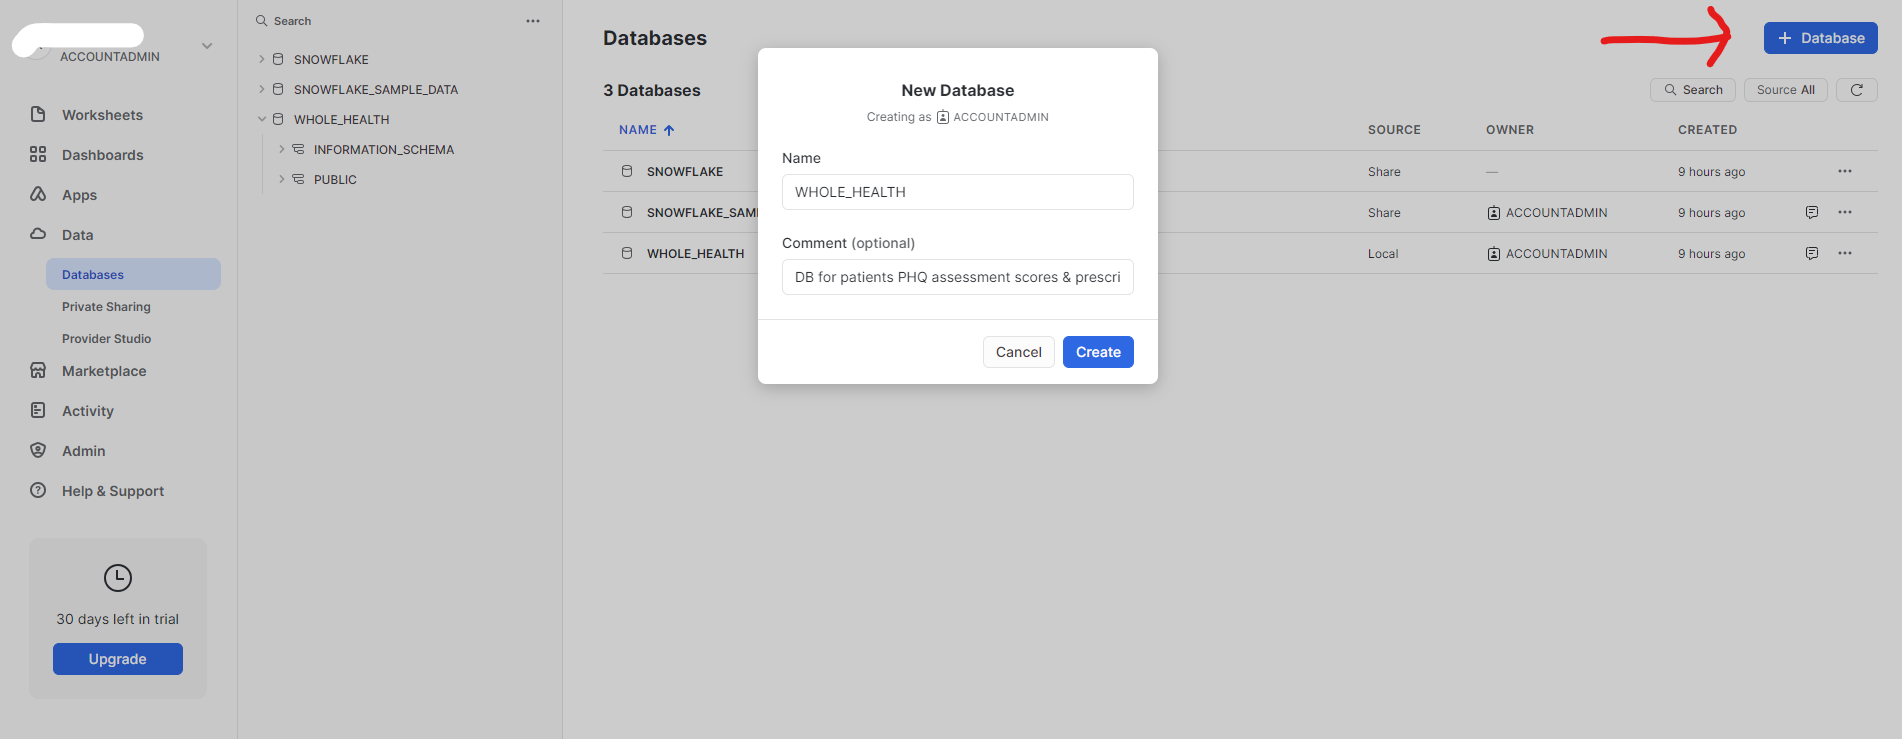


<br>

Now the database has been created 


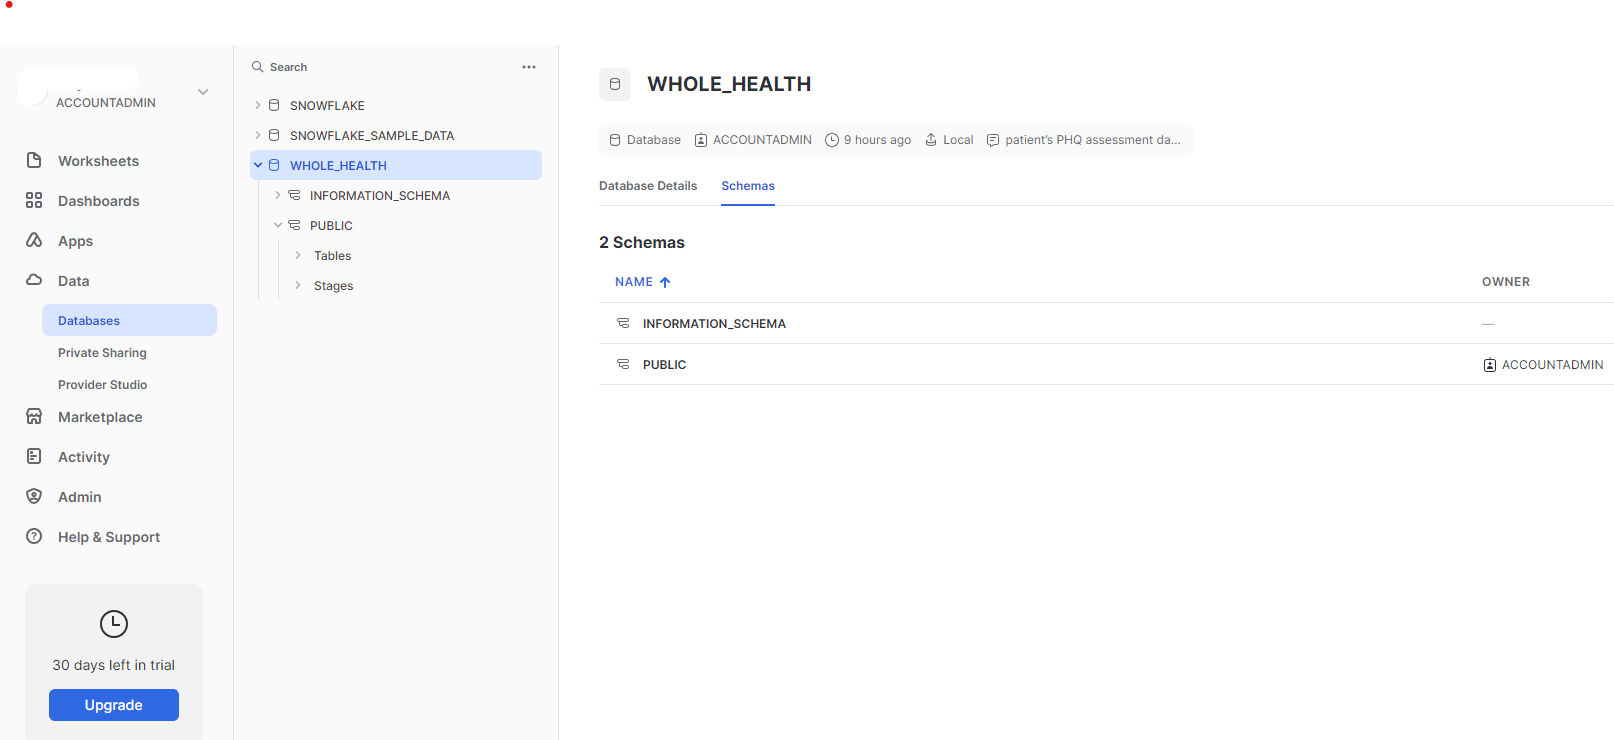

<br>

Next steps include:
- 1) Click on worksheets tab (top left just below the Snowflake account name)
- 2) New Worksheet (The + Icon at the top right corner)
- 3) Choose `SQL Worksheet` from the drop down menu

See screenshot below.


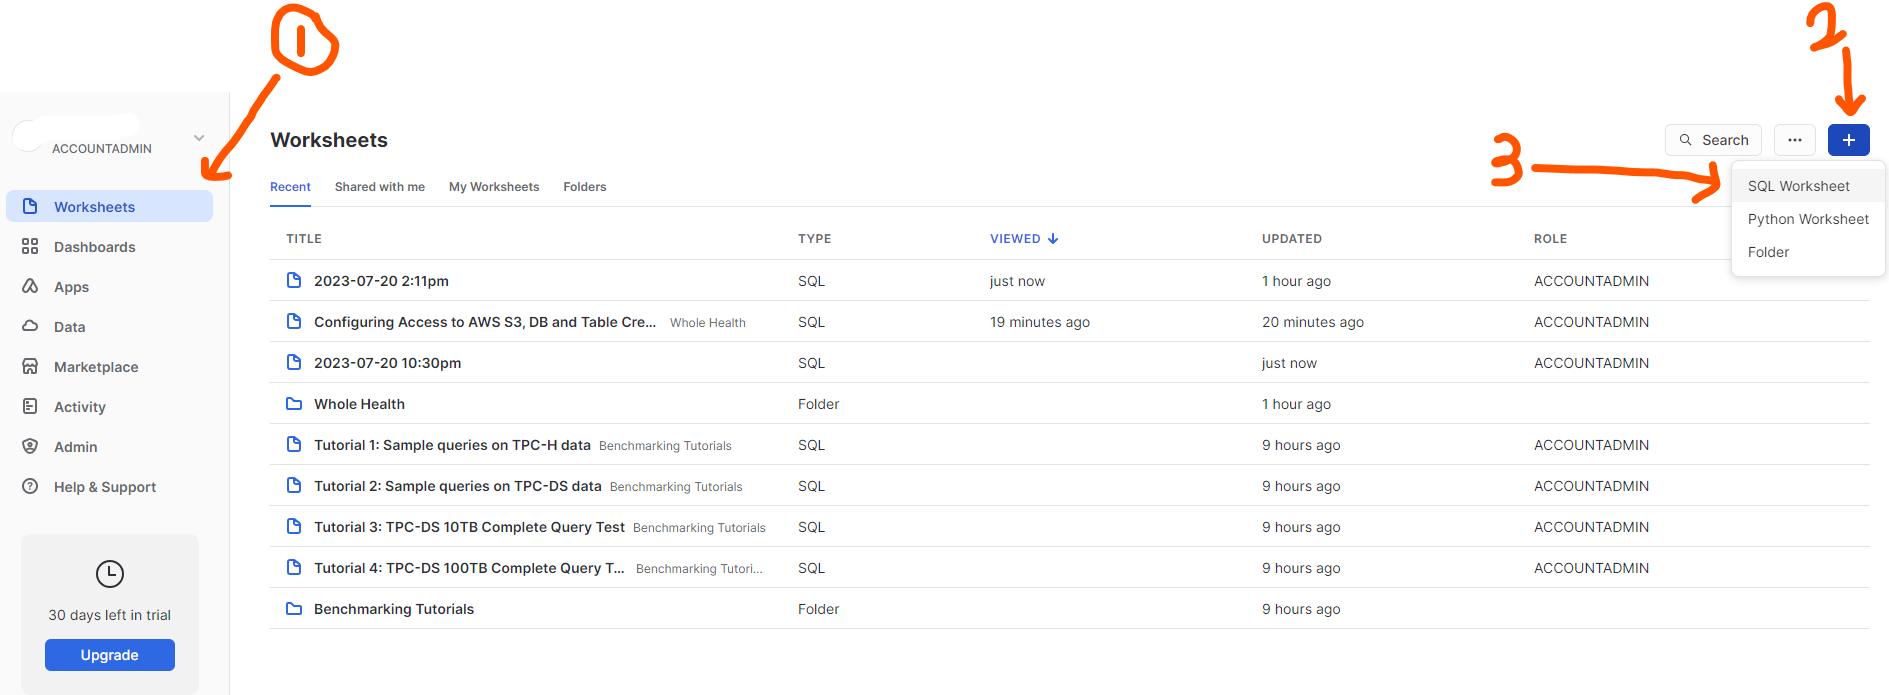

<br>

Next I renamed my worksheet, created a folder, and then moved my worksheet there. Just so I have all my worksheets for this project in one location.
See screenshot below.


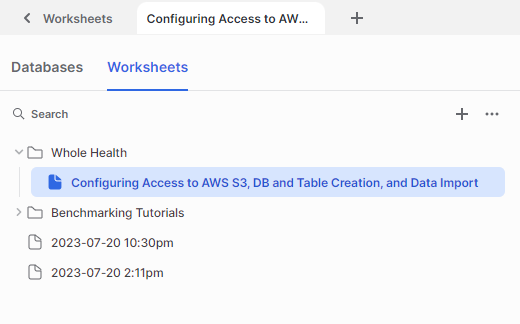

<br>

Now open the worksheet and run the Snowflake SQL statements below to set up the integration with AWS S3

<br>



## Setting up the integration with AWS S3 


**Note:** I have used placeholders like `<account-id>`, `<role-name>`, `<s3-bucket-name>` for security purposes. Replace all placeholders with your actual info.

Refer to [Snowflake Documentation](https://docs.snowflake.com/en/user-guide/data-load-s3-config-storage-integration) for more.

<br>

**SQL Statements in Snowflake**

```sql
-- Setup the integration with AWS S3 where the CSV objects containing the required data are stored
-- This data would be ingested into tables here in snowflake
DROP STORAGE INTEGRATION IF EXISTS aws_s3_integration;

CREATE STORAGE INTEGRATION aws_s3_integration
TYPE = EXTERNAL_STAGE
STORAGE_PROVIDER = 'S3'
ENABLED = TRUE
STORAGE_AWS_ROLE_ARN = 'arn:aws:iam::<account-id>:role/<role-name>'
STORAGE_ALLOWED_LOCATIONS = ('s3://<s3-bucket-name>/');
--------------------------------------------------------
```

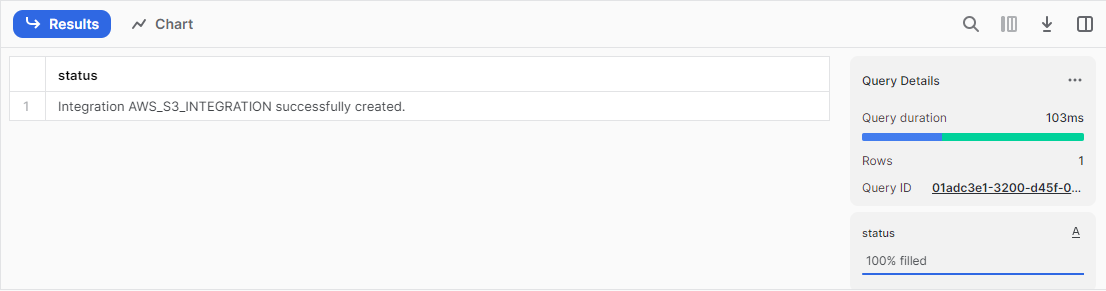

<br>


```sql

-- Retrieving the AWS IAM user for this Snowflake account
DESC INTEGRATION aws_s3_integration;
------------------------------------

```

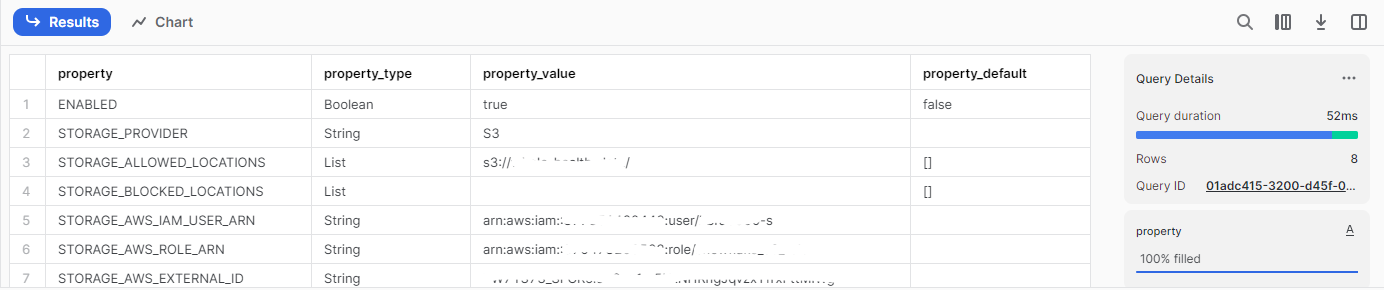

<br>

**Note:** _Actual values for my AWS IAM user credentials have been erased for security_

<br>


```sql

-- Showing roles here in snowflake to decide which role to use when granting access to the integration
SHOW ROLES;
-----------

```

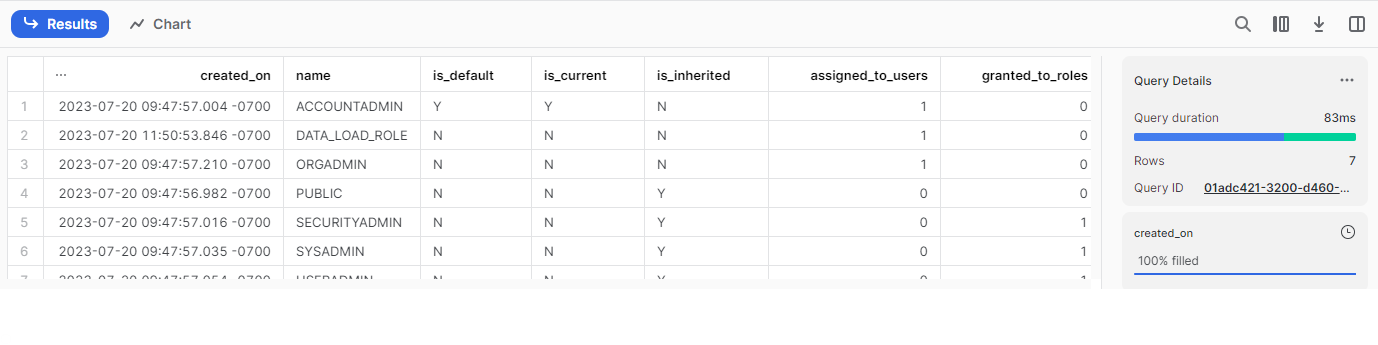


Now I can see all the roles associated with my Snowflake account. To keep things simple, I would go with the `ACCOUNTADMIN` role. But in work-scenarios, this is where I could create a new role and define permissions and privileges.

<br>


```sql

-- Granting usage of the integration to the accountadmin role
GRANT USAGE ON INTEGRATION aws_s3_integration TO ROLE accountadmin;
-------------------------------------------------------------------

-- Using the whole_health database and public schema that I already created
USE DATABASE whole_health;
USE SCHEMA public;
------------------

```

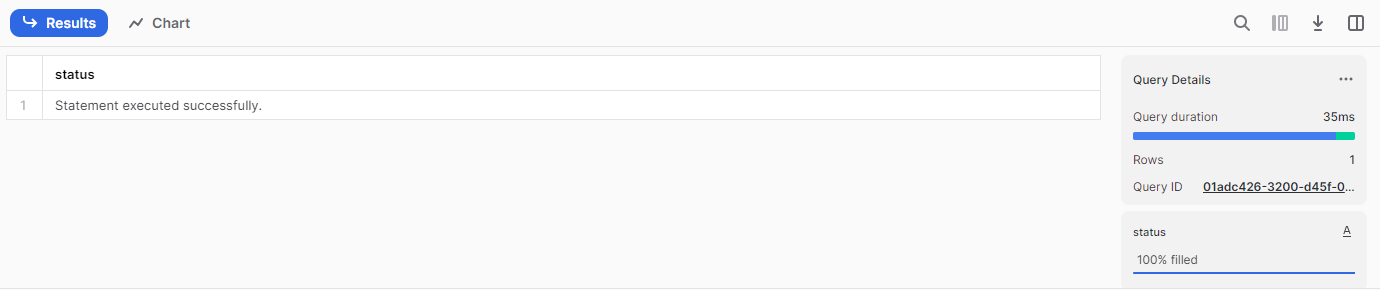


```sql

-- Creating an external stage that references the AWS S3 bucket that I want to import data from
DROP STAGE IF EXISTS my_s3_stage;

CREATE OR REPLACE STAGE my_s3_stage
URL = 's3://<s3-bucket-name>/'
CREDENTIALS = ( AWS_KEY_ID = '<string>' AWS_SECRET_KEY = '<string>')
FILE_FORMAT = (TYPE = CSV FIELD_OPTIONALLY_ENCLOSED_BY=','); --Check what your file type is and its delimiter, I used comma (,) here since it's a CSV file
------------------------------------------------------------

```

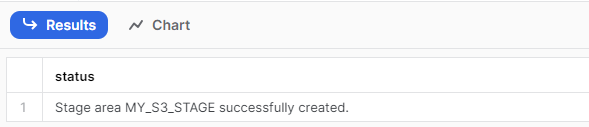


```sql

-- Listing the contents of the external stage I just created, to make sure I have access to the files in the s3 bucket
LIST @my_s3_stage;
------------------

```
<br>

Now I can see all 3 csv files containing the data that I want to import. See below

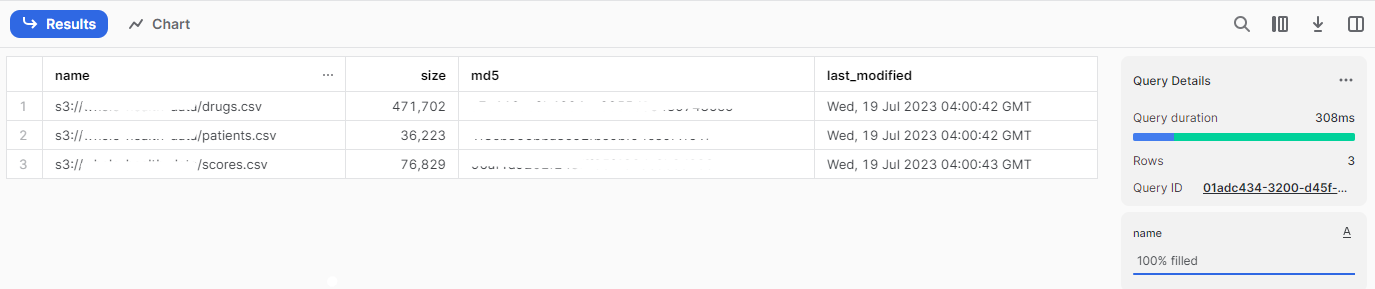

## Creating the 3 Database Tables and Storing the Data


```sql

-- Creating the drugs table within the database public schema
DROP TABLE IF EXISTS public.drugs;

CREATE TABLE IF NOT EXISTS drugs (
patient_id integer,
written_date date,
drug_class character varying,
drug_name character varying
    );
-- Then load data into the newly created table, from the csv file in the S3 bucket that was staged in "my_s3_stage"
COPY INTO drugs
FROM @my_s3_stage/drugs.csv
FILE_FORMAT = (TYPE = CSV FIELD_DELIMITER=',' SKIP_HEADER = 1); -- Using the comma (,) delimiter and skipping the first row which only contains the column names
---------------------------------------------------------------

```

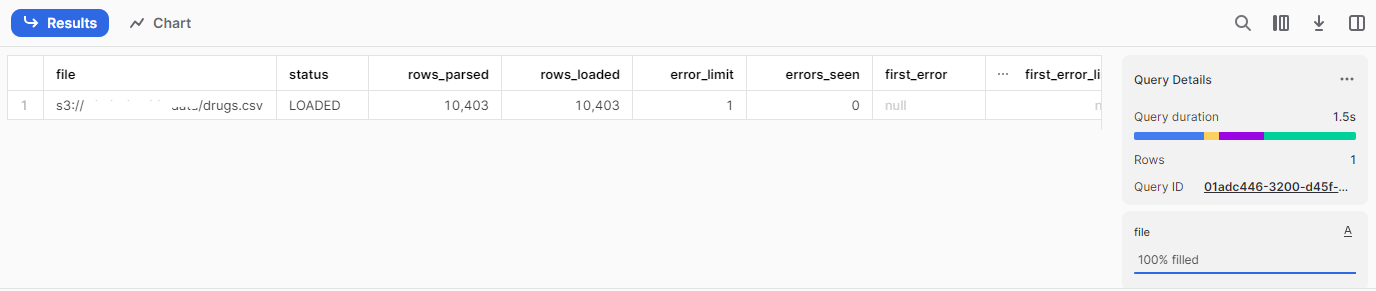

```sql

-- Confirming that my data from the drugs.csv file in s3 was copied into my Snowflake database table successfully,
-- by viewing a snippet of the drugs table
SELECT *
FROM drugs
LIMIT 3; -- Limiting the query output, thus shortening query time to save costs
--------

```

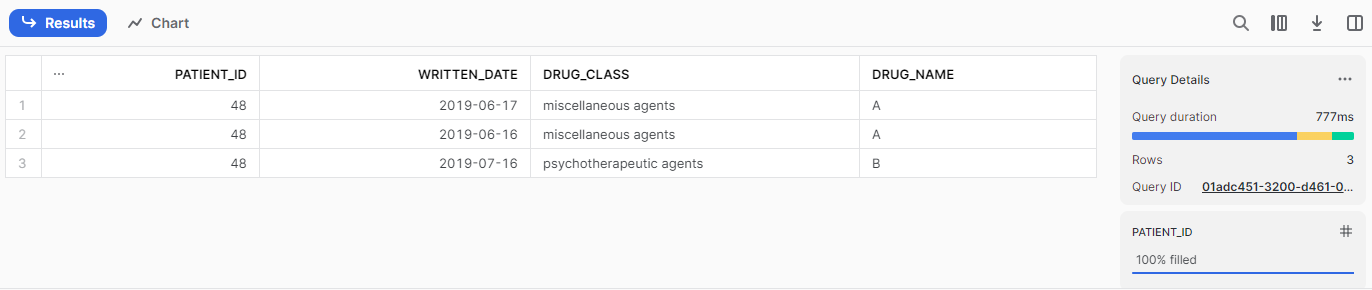


```sql

-- Creating the patients table
DROP TABLE IF EXISTS public.patients;

CREATE TABLE IF NOT EXISTS patients (
patient_id character varying, -- In the csv file, there's a string before the id e.g patient_id_1234, so VARCHAR for now
sex character varying
    );
-- Then load data into the newly created table, from the csv file in the S3 bucket that was staged in "my_s3_stage"
COPY INTO patients
FROM @my_s3_stage/patients.csv
FILE_FORMAT = (TYPE = CSV FIELD_DELIMITER=',' SKIP_HEADER = 1);
---------------------------------------------------------------

```

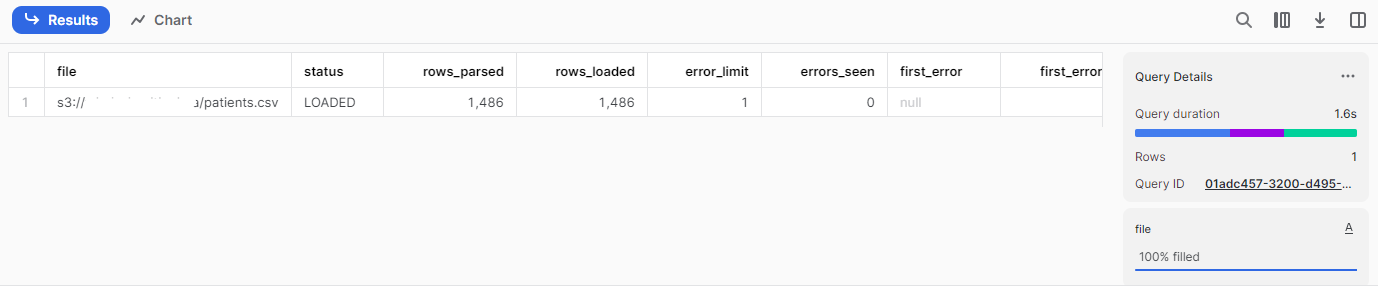


```sql

-- Confirming successful data import
SELECT *
FROM patients
LIMIT 3; -- Limiting the query output, thus shortening query time to save costs
--------

```

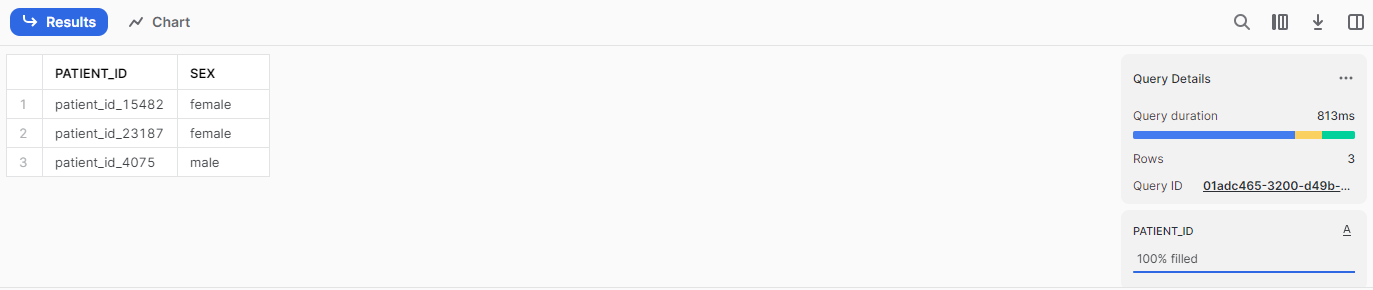

```sql

-- Last but not least, creating the scores table
DROP TABLE IF EXISTS public.scores;

CREATE TABLE IF NOT EXISTS scores (
patient_id integer,
phq_score integer,
score_date date
    );
-- Then load data into the newly created table, from the csv file in the S3 bucket that was staged in "my_s3_stage"
COPY INTO scores
FROM @my_s3_stage/scores.csv
FILE_FORMAT = (TYPE = CSV FIELD_DELIMITER=',' SKIP_HEADER = 1);
---------------------------------------------------------------

```

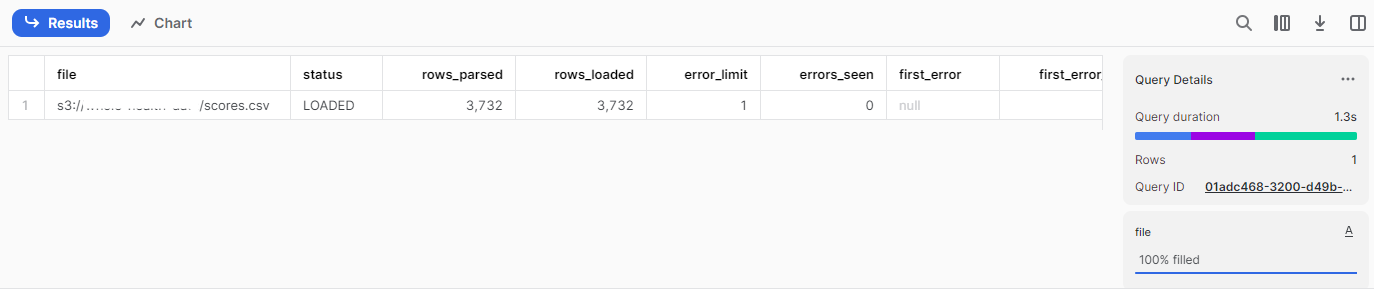



```sql

-- Confirming successful data import
SELECT *
FROM scores
LIMIT 3; -- Limiting the query output, thus shortening query time to save costs
--------

```

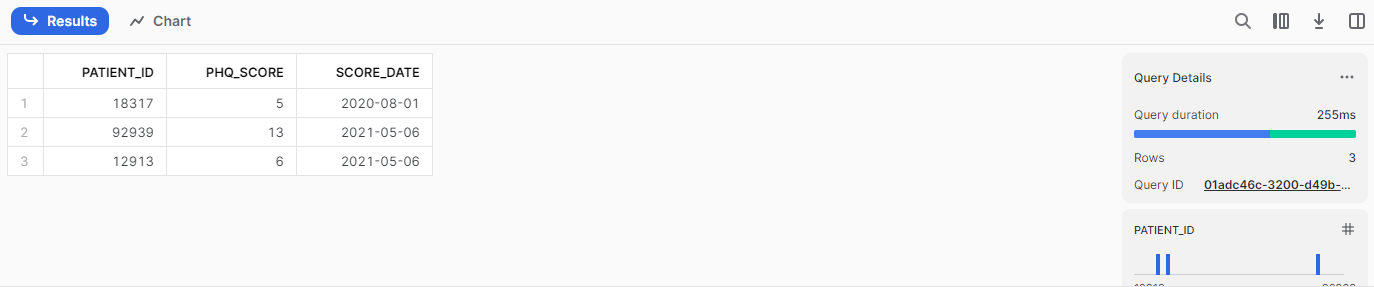

## Querying the Data in Snowflake to Answer Business Questions


### Summary of Patients Table

```sql

--Number of records of patients
SELECT COUNT(*) as record_count
FROM patients;
-- Observation: There are 1486 records in this table
----------------------------------------------------

```

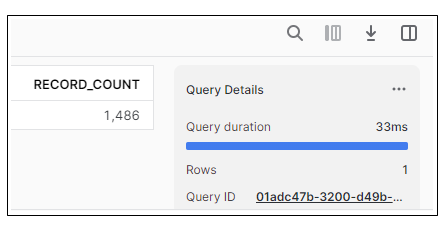

```sql

-- Counting number of distinct records to make sure there are no duplicates
SELECT COUNT(DISTINCT patient_id) AS distinct_patient_count
FROM patients;
-- Observation: Distinct record count is the same as above. There are no duplicates
--------------

```

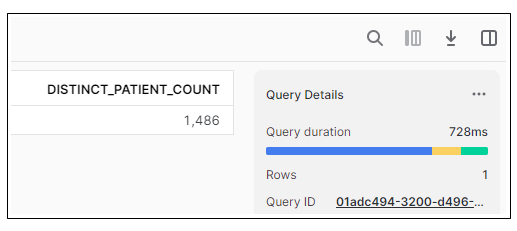

```sql

--Gender Distribution
SELECT 
    sex, 
    COUNT(*) AS count,
    ROUND((COUNT(*) * 100.0) / (SELECT COUNT(*) FROM patients), 1) AS percentage
FROM patients 
GROUP BY sex
ORDER BY count DESC;
-- Observation: Approx. 79% are females and Approx. 21% are males. There is one record with a missing gender value
-------------------

```


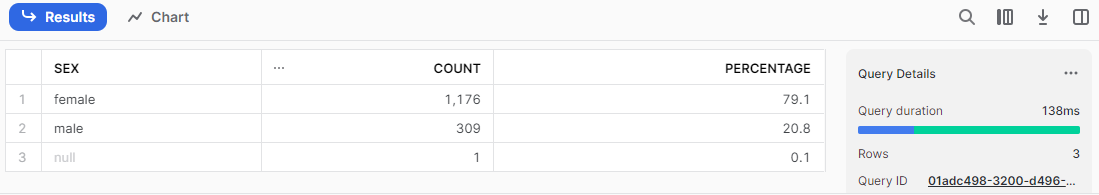

```sql

-- Viewing first 3 rows of the patients table
SELECT *
FROM patients
LIMIT 5;
-- Observation: Quick overview of the patients table reveals that data cleaning is to be performed on the patient_id variable 
-------------

```

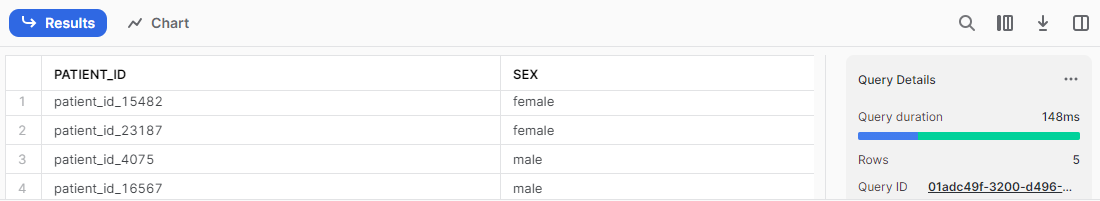

```sql

-- Extracting the actual patient id from each string and Converting the string value to an integer
SELECT 
    CAST(SUBSTR(patient_id, 12) AS INT) AS patient_id
FROM patients;
--------------

```

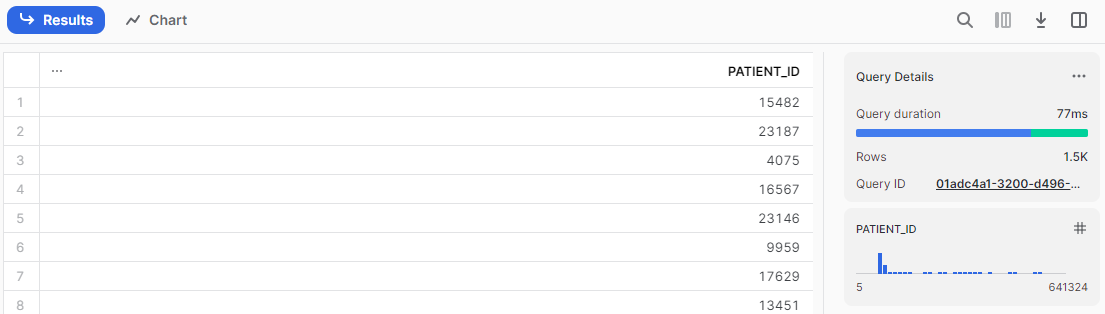


<br>

Let's move on to the `scores` table

### Summary of Scores Table

